In [1]:
%matplotlib inline
import matplotlib.pylab as plt

import time

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.optimizers import Adam, Adagrad, Adadelta, SGD
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError
from tensorflow.keras.callbacks  import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout, BatchNormalization, ReLU, LeakyReLU
from tensorflow.keras.layers import RepeatVector, Flatten, Conv1D, UpSampling1D, MaxPooling1D, Reshape, Permute

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

In [2]:
train_y = pd.read_parquet('../data/graphs.train.parquet')
train_x   = pd.read_parquet('../data/params.train.parquet')

val_y      = pd.read_parquet('../data/graphs.val.parquet', )
val_x = pd.read_parquet('../data/params.val.parquet', )

test_y  = pd.read_parquet('../data/graphs.test.parquet')
test_x = pd.read_parquet('../data/params.test.parquet')

# extra dataset: 0.5, 1.0, 1.5 이외의 loca size dataset
ext_y  = pd.read_parquet('../data/graphs.ext.parquet')
ext_x = pd.read_parquet('../data/params.ext.parquet')

In [3]:
def append_locatype(df):
    df['loca_type']=df.index.str[:3]#.map(np.float32)
    return df.astype(np.float32)

train_x=append_locatype(train_x)
val_x=append_locatype(val_x)
test_x=append_locatype(test_x)
ext_x=append_locatype(ext_x)

In [4]:
print("파일 이름별로 파라미터를 정리하여 training feature로 사용")
print("Training feature: ", train_x.shape)
train_x.head()

파일 이름별로 파라미터를 정리하여 training feature로 사용
Training feature:  (4735, 9)


,param_1,param_2,param_3,param_4,param_5,param_6,param_7,param_8,loca_type
name,,,,,,,,,
1.0inch-#2000_csv_Run-1978,0.202015,0.202015,0.399885,0.600115,0.620863,0.160431,0.160431,0.0,1.0
0.5inch-#2000_csv_Run-1675,0.240198,0.240198,0.642439,0.357560,0.815345,0.179042,0.179042,0.0,0.5
1.0inch-#2000_csv_Run-1806,0.286265,0.286265,0.701312,0.298688,0.852294,0.215236,0.215236,0.0,1.0
1.5inch-#2000_csv_Run-1891,0.226914,0.226914,0.287934,0.712066,0.498429,0.065139,0.065139,0.0,1.5
1.5inch-#2000_csv_Run-478,0.277137,0.277138,0.461141,0.538859,0.677740,0.063758,0.063758,0.0,1.5


In [5]:
print("training label은 3차원 데이터임(file별, 시간별, feature별).\n"
      "편의상 파일 순서대로 10000초씩을 저장해두고 사용시에 reshape.")
print("Training label: ", train_y.shape)
train_y.head()

training label은 3차원 데이터임(file별, 시간별, feature별).
편의상 파일 순서대로 10000초씩을 저장해두고 사용시에 reshape.
Training label:  (47350000, 3)


,col_40,col_46,col_47
index,,,
0,0.995508,1.0,0.122066
1,0.993052,1.0,0.121121
2,0.990525,1.0,0.121057
3,0.990033,1.0,0.120934
4,0.990525,1.0,0.120940


In [6]:
# 포지서널 인코딩 루틴. Original tranformer 모델의 것과 동일

def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2*(i//2))/np.float32(d_model))
    return pos*angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    angle_rads[:,0::2] = np.sin(angle_rads[:,0::2])
    angle_rads[:,1::2] = np.cos(angle_rads[:,1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [7]:
# MultiHeadAttention에 사용할 scaled dot product attention.
# original tranformer의 것과 동일

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], k.dtype)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    output = tf.matmul(attention_weights, v)
    
    return output, attention_weights

In [8]:
#  scaled dot product attention 예제:
temp_inp = tf.random.uniform([100,10])
temp_graph = tf.random.uniform([600,10])

scaled_dot_product_attention(temp_graph, temp_inp, temp_inp, None)[0]

<tf.Tensor: id=24, shape=(600, 10), dtype=float32, numpy=
array([[0.44322386, 0.52838904, 0.53301406, ..., 0.5215776 , 0.49816966,
        0.49211153],
       [0.43150812, 0.52518564, 0.5327921 , ..., 0.51964927, 0.49228308,
        0.50567484],
       [0.43012935, 0.5171208 , 0.54256535, ..., 0.5141939 , 0.52127445,
        0.4880644 ],
       ...,
       [0.42890725, 0.52451605, 0.54236245, ..., 0.53513145, 0.5117628 ,
        0.5027959 ],
       [0.429008  , 0.5303279 , 0.5442541 , ..., 0.51120275, 0.5101416 ,
        0.49715292],
       [0.42566124, 0.51955205, 0.53770936, ..., 0.52767396, 0.4961386 ,
        0.5056725 ]], dtype=float32)>

In [9]:
# Multi-head attention. Original transformer 것을 사용.

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        assert d_model%self.num_heads == 0
        
        self.depth = d_model // self.num_heads
        
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        
        self.dense = tf.keras.layers.Dense(d_model)
        
    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """

        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0,2,1,3])
    
    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]
        
        q = self.wq(q)
        k = self.wq(k)
        v = self.wq(v)
        
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0,2,1,3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        output = self.dense(concat_attention)
        
        return output, attention_weights

In [10]:
# MultiHeadAttention 사용 예제
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
x_inp = tf.random.uniform((1, 6, 100))
y_graph = tf.random.uniform((1, 500, 100))
out, atten = temp_mha(x_inp, x_inp, y_graph, mask=None)

out.shape, atten.shape

(TensorShape([1, 500, 512]), TensorShape([1, 8, 500, 6]))

In [11]:
#Multi-head attention 모둘 위에는 point-wise feed forward network이 사용된다.
#d_model: 모델 전반에 걸쳐 사용되는 dimension
#dff: point_wise_feed_forward_network내부적으로만 사용되는 hidden layer의 dimension.
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
    ])

#### Original transformer는 번역을 위한 모델이며 encoder(원문)-decoder(번역문) 구조로 되어 있다.
#### 본 예제에서는  encoder 대신에 8-dim parameter를 위한 dense layer 하나와 그래프 예측을 위한 변형된 decoder(original transformer 디코더 레이어에서 하단의 self-attention을 제외) 구조로 이루어져 있다.

In [12]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)
        
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
        
    def call(self, x, enc_output, training, look_ahead_mask):
        ## Note: self-attention 구조는 제외. 시간과 메모리 문제 때문.
        ##       커멘트만 제거하면 사용 가능. 
#         attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
#         attn1 = self.dropout1(attn1, training=training)
#         out1 = self.layernorm1(attn1+x)
        out1=x
        attn_weights_block1=None
        
        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, None)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2+out1)
        
        ffn_out = self.ffn(out2)
        ffn_out = self.dropout3(ffn_out, training=training)
        out3 = self.layernorm3(ffn_out+out2)
        
        return out3, attn_weights_block1, attn_weights_block2

In [13]:
# Self-attention 에 사용되는 mask. 미래시간의 data를 가리는데 사용
def create_look_ahead_mask(size):
    mask = tf.linalg.band_part(tf.ones((size, size)), 0, -1)
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [14]:
# decoder layer 사용 예제
print(y_graph.shape, x_inp.shape)
sample_decoder_layer = DecoderLayer(100, 5, 2048)
look_ahead_mask=create_look_ahead_mask(500)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    y_graph, x_inp, training=False, look_ahead_mask=look_ahead_mask)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

(1, 500, 100) (1, 6, 100)


TensorShape([1, 500, 100])

In [15]:
# 위에 설명한대로 변형된 decoder로 이루어진 transformer 모델

class DecoderTransformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 graph_dim, time_len, rate=0.1):
        super(DecoderTransformer, self).__init__()
        
        #Encoder를 8-dim input parameters를 위한 dense layer로 대체
        self.inp_encoder = Dense(d_model)
        
        self.d_model = d_model
        self.num_layers = num_layers
        
        #단어가 아닌 시계열 데이터므로 Embedding 은 dense layer로 대체.
        self.embedding = tf.keras.layers.Dense(d_model)
        
        self.pos_encoding = positional_encoding(time_len, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
        
        self.final_layer = tf.keras.layers.Dense(graph_dim)
        
    def call(self, target_graphs, input_params, training, look_ahead_mask):
        seq_len = tf.shape(target_graphs)[1]
        
        x = self.embedding(target_graphs)        
        enc_output = self.inp_encoder(input_params)
        
        attention_weights = {}        
        x += self.pos_encoding[:,:seq_len, :]
        x = self.dropout(x, training=training)
        for i, layer in enumerate(self.dec_layers):
            x, block1, block2 = layer(x, enc_output, training, look_ahead_mask)
            
            attention_weights[f'decoder_layer{i}_block1'] = block1
            attention_weights[f'decoder_layer{i}_block2'] = block2
            
            
        final_output = self.final_layer(x)
            
        return final_output, attention_weights

In [16]:
#Sample model for testing

sample_decoder = DecoderTransformer(num_layers=2, d_model=100, num_heads=5, dff=2048,
                         graph_dim=100, time_len=500)

look_ahead_mask=create_look_ahead_mask(500)


sample_decoder_output, _ = sample_decoder(
    y_graph, x_inp, training=False, look_ahead_mask=look_ahead_mask)

y_graph.shape, sample_decoder_output.shape

(TensorShape([1, 500, 100]), TensorShape([1, 500, 100]))

In [17]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
        
        self.norm = tf.math.rsqrt(self.d_model)
        
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step*(self.warmup_steps**-1.5)
        return self.norm*tf.math.minimum(arg1, arg2)

In [18]:
# 모델 하이퍼 파라미터.
# 학습시 num_layers*8.8GB 정도의 GPU 메모리 필요.

num_layers = 1
d_model = 128
dff = 512
num_heads = 8
dropout_rate=0.1

n_graphs = 3
time_len = 10000
time_cutoff=10001

EPOCHS=200
BUFFER_SIZE=1000
BATCH_SIZE=20

In [19]:
learning_rate=CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

transformer = DecoderTransformer(num_layers=num_layers, d_model=d_model,
                                 num_heads=num_heads, dff=dff, graph_dim=n_graphs, time_len=time_cutoff-1)

In [20]:
trainset = tf.data.Dataset.from_tensor_slices((train_x.values, train_y.values.reshape(-1, 10000, 3)))
valset = tf.data.Dataset.from_tensor_slices((val_x.values, val_y.values.reshape(-1, 10000, 3)))
testset = tf.data.Dataset.from_tensor_slices((test_x.values, test_y.values.reshape(-1, 10000, 3)))

train_dataset = trainset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = valset.batch(BATCH_SIZE)

In [21]:
loss_function = tf.keras.losses.MeanAbsoluteError()
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.MeanAbsoluteError(name='train_accuracy')


def train_step(inp_params, target_graphs):
    # 다음시간의 그래프를 예측하는 학습을 함.
    # Attention 메커니즘을 사용하기 때문에 과거 시간의 값은 참고할 수 있으나
    # 미래 시간의 값을 사용하는것은 look_ahead_mask 으로 차단됨.
    tar_inp = target_graphs[:, :-1, :]
    tar_real = target_graphs[:, 1:, :]
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
    
    with tf.GradientTape() as tape:
        predictions, _ = transformer(tar_inp, inp_params, True, look_ahead_mask)
        loss = loss_function(tar_real, predictions)
        
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)
    

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.MeanAbsoluteError(name='val_accuracy')


def val_step(inp_params, target_graphs):
    tar_inp = target_graphs[:, :-1, :]
    tar_real = target_graphs[:, 1:, :]
    
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar_inp)[1])
    
    predictions, _ = transformer(tar_inp, inp_params, True, look_ahead_mask)
    loss = loss_function(tar_real, predictions)
    
    val_loss(loss)
    val_accuracy(tar_real, predictions)

In [22]:
checkpoint_path = '../data/checkpoints/tf.loca_type.0.train/'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=50)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f'Latest checkpoint restored!! {ckpt_manager.latest_checkpoint}')

Latest checkpoint restored!! ../data/checkpoints/tf.loca_type.0.train/ckpt-8


In [ ]:
for epoch in range(EPOCHS):
    start = time.time()
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    for (batch, (input_params, target_graphs)) in enumerate(train_dataset):
        input_params = tf.expand_dims(input_params, 1)
        train_step(input_params, target_graphs[:,:time_cutoff,:])
        
        if batch % 10 == 0:
            print(f'Epoch {epoch+1} Batch {batch}'
                  f' Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
            
    print(f'Epoch {epoch+1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
    print(f"Time taken for 1 epoch: {time.time()-start} secs")
    
    val_loss.reset_states()
    val_accuracy.reset_states()
    
    for input_params, target_graphs in val_dataset:
        input_params = tf.expand_dims(input_params, 1)
        val_step(input_params, target_graphs[:,:time_cutoff,:])
    print(f'Epoch {epoch+1} val_loss {val_loss.result():.4f} val_acc {val_accuracy.result():.4f}')
    
    
    if (epoch + 1) % 20 == 0:
        ckpt_save_path = ckpt_manager.save()
        print (f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

In [23]:
[(inp,y)]=testset.shuffle(buffer_size=1000).batch(10).take(1)

y=y[:,:time_cutoff-1,:]
look_ahead_mask=create_look_ahead_mask(y.shape[1])
# look_ahead_mask=create_look_ahead_mask(y.shape[1]//10)
preds, _ = transformer(y, inp, False, look_ahead_mask)

In [24]:
output = y[:,:1,:]
inp,output

start=time.time()
for i in range(time_cutoff-1):
    look_ahead_mask=create_look_ahead_mask(output.shape[1])
    preds2, _ = transformer(output, inp, False, look_ahead_mask)
    output=tf.concat([output, preds2[:,-1:,:]], axis=1)
    if i%100==0:
        print(time.time()-start, i, output.shape)

0.01718425750732422 0 (10, 2, 3)
0.7607595920562744 100 (10, 102, 3)
1.5272603034973145 200 (10, 202, 3)
2.340780258178711 300 (10, 302, 3)
3.2086637020111084 400 (10, 402, 3)
4.1379711627960205 500 (10, 502, 3)
5.109239339828491 600 (10, 602, 3)
6.058582305908203 700 (10, 702, 3)
7.168497323989868 800 (10, 802, 3)
8.277185678482056 900 (10, 902, 3)
9.350180387496948 1000 (10, 1002, 3)
10.487695932388306 1100 (10, 1102, 3)
11.73184061050415 1200 (10, 1202, 3)
12.978079795837402 1300 (10, 1302, 3)
14.24112844467163 1400 (10, 1402, 3)
15.519165754318237 1500 (10, 1502, 3)
16.84598469734192 1600 (10, 1602, 3)
18.326965808868408 1700 (10, 1702, 3)
20.295445203781128 1800 (10, 1802, 3)
22.29533553123474 1900 (10, 1902, 3)
24.504973888397217 2000 (10, 2002, 3)
26.717411518096924 2100 (10, 2102, 3)
29.05945634841919 2200 (10, 2202, 3)
31.4782977104187 2300 (10, 2302, 3)
33.84483051300049 2400 (10, 2402, 3)
36.24102258682251 2500 (10, 2502, 3)
38.71041440963745 2600 (10, 2602, 3)
41.3282268047

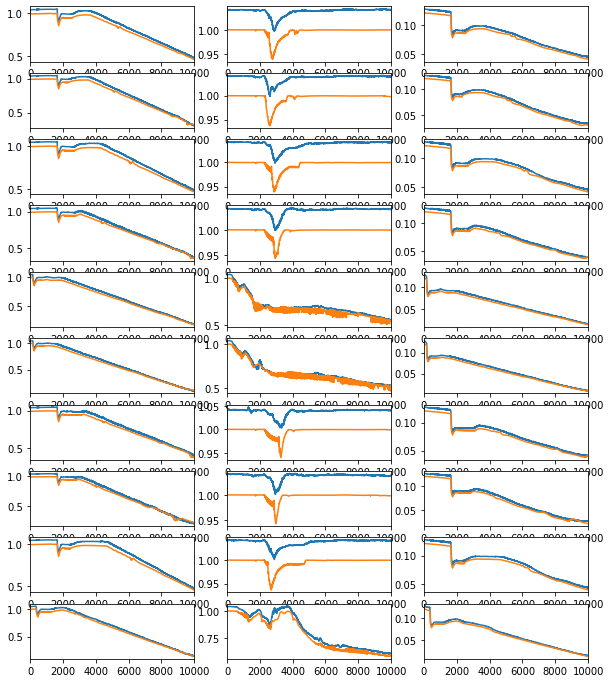

In [29]:
fig, axess = plt.subplots(10,3, figsize=(10,12))

for idx,axes in enumerate(axess):
    df_pred=pd.DataFrame(output.numpy()[idx])
    df_y=pd.DataFrame(y.numpy()[idx])

    for col, ax in enumerate(axes):
        df_pred[col].plot(ax=ax)
        df_y[col].plot(ax=ax)

In [26]:
extset = tf.data.Dataset.from_tensor_slices((ext_x.values, ext_y.values.reshape(-1, 10000, 3)))

[(inp_ext,y_ext)]=extset.shuffle(buffer_size=1000).batch(10).take(1)

output_ext = y[:,:1,:]

start=time.time()
for i in range(time_cutoff-1):
    look_ahead_mask=create_look_ahead_mask(output_ext.shape[1])
    preds_ext, _ = transformer(output_ext, inp_ext, False, look_ahead_mask)
    output_ext=tf.concat([output_ext, preds_ext[:,-1:,:]], axis=1)
    if i%100==0:
        print(time.time()-start, i, output_ext.shape)

0.010196208953857422 0 (10, 2, 3)
0.7491095066070557 100 (10, 102, 3)
1.5291030406951904 200 (10, 202, 3)
2.347426414489746 300 (10, 302, 3)
3.1885170936584473 400 (10, 402, 3)
4.032283544540405 500 (10, 502, 3)
4.903376340866089 600 (10, 602, 3)
5.861297845840454 700 (10, 702, 3)
6.847326993942261 800 (10, 802, 3)
7.871611833572388 900 (10, 902, 3)
8.941437721252441 1000 (10, 1002, 3)
10.05139708518982 1100 (10, 1102, 3)
11.22199821472168 1200 (10, 1202, 3)
12.401665925979614 1300 (10, 1302, 3)
13.633220434188843 1400 (10, 1402, 3)
14.9009108543396 1500 (10, 1502, 3)
16.185817003250122 1600 (10, 1602, 3)
17.528412103652954 1700 (10, 1702, 3)
18.91712498664856 1800 (10, 1802, 3)
20.35398268699646 1900 (10, 1902, 3)
21.832610607147217 2000 (10, 2002, 3)
23.352386713027954 2100 (10, 2102, 3)
24.932947874069214 2200 (10, 2202, 3)
26.563947677612305 2300 (10, 2302, 3)
28.243830919265747 2400 (10, 2402, 3)
29.940648794174194 2500 (10, 2502, 3)
31.677408933639526 2600 (10, 2602, 3)
33.479349

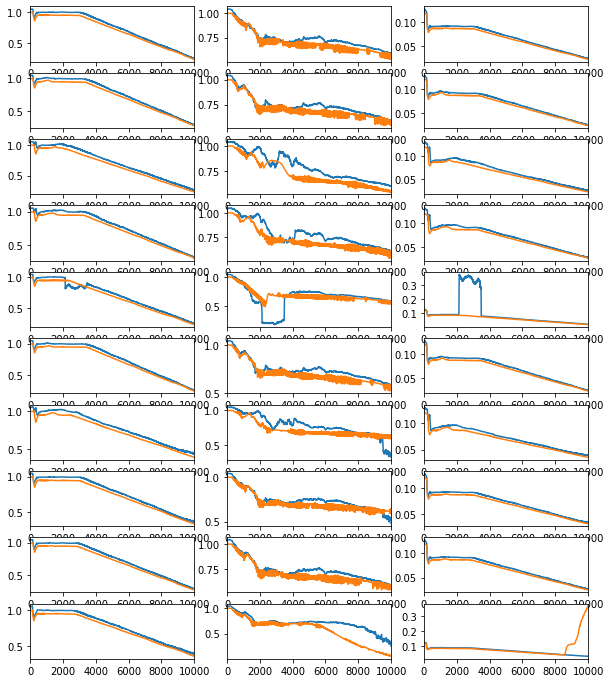

In [28]:
fig, axess = plt.subplots(10,3, figsize=(10,12))

for idx,axes in enumerate(axess):
    df_pred=pd.DataFrame(output_ext.numpy()[idx])
    df_y=pd.DataFrame(y_ext.numpy()[idx])

    for col, ax in enumerate(axes):
        df_pred[col].plot(ax=ax)
        df_y[col].plot(ax=ax)